In [112]:
import numpy as np
import time
import math
import modules as md
import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches




#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

## Newton

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;


## PN 

In [3]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel + runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
    return a # return acceleration

def JerkPN(r,v,acc,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    #JePNLO4 = np.zeros((len(r),3))
    #JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*acc[i]).sum()                                                  
                vad = (vrel*acc[i]).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*acc[i] + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                #JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*acc[i]+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                #JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 #+ JePNLO4 + JePNLO5 
    return JePNLOt

## Tides 

In [4]:
def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            ra = np.linalg.norm(r[i,:]-r[j,:]) #dot product
            rvec = r[i,:]-r[j,:]
            if (i != j):
                a[i,:] += -(9.)*ne[i]*((m[j]**2)/m[i])*(rvec)/(ra**8.0) #Acceleration at each time step 
    return a # return acceleration

def Jerktide(r,v,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Je[i,:] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
    return Je;



In [37]:
def HermiteUpdatePNtidedt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN + aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aTdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aPNp + aTp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp +  aTdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    #a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    #a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    #ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    #a2c = a2 + dt*a3    
    #acn = ((ac**2).sum())**(1./2) #dot product
    #a2cn = ((a2c**2).sum())**(1./2)
    #adotpn = ((aTdotp**2).sum())**(1./2)
    #a3n = ((a3**2).sum())**(1./2)
    #dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, dtp, time #, aN_res, adotN_res, a_res, adot_res, 


In [38]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
bh3nscol = md.Binary(bh3, ns, ns.radi*7, 0) ##primary, secondary, orbital distance (Rsun), eccentricity

print(bh3nscol.orbd)
print(bh3nscol.tideeffsec)

print(ns.radi)
print(bh3nscol.tidalrsec)


62.230000000000004
0.0005592401975367406
8.89
14.305334381906748


In [39]:
#accu = 0.0000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 9*bh3nscol.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [40]:
rTPN,vTPN,dtpTPN, timeTPN = Hermite4thPNtidedt(bh3,ns, bh3nscol, Nsteps, dt)

In [43]:
print(min(dtpTPN))
print(max(dtpTPN))

3.5479161887344035e-05
0.0029997157875437104


In [44]:
#timeTPN = np.zeros_like(timePNTns)

#timeTPN[0] = timePNTns[0]

#for i in range(len(timePNTns)-1):
#    timeTPN[i+1] = timePNTns[i+1] + timeTPN[i]
    
    #timePNT[i] = timecount
    
#print(i)

In [45]:
print(timeTPN)

[0.00000000e+00 1.00000000e-03 1.47535592e-03 ... 1.51861352e+03
 1.51861355e+03 1.51861359e+03]


No handles with labels found to put in legend.


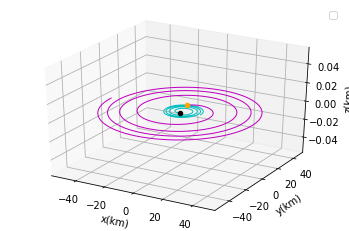

In [161]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rTPN[0][0], rTPN[0][1], rTPN[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rTPN[1][0], rTPN[1][1], rTPN[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rTPN[0][0][-1], rTPN[0][1][-1], rTPN[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rTPN[1][0][-1], rTPN[1][1][-1], rTPN[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [49]:
rrelTPN = rTPN[0] - rTPN[1]
vrelTPN = vTPN[0] - vTPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dTPN = np.zeros(len(rrelTPN .T)) 

for i in range(len(rrelTPN.T)):
    dTPN[i] = np.linalg.norm(rrelTPN.T[i])
    
#Obtain the relative velocity
vnTPN = np.zeros(len(vrelTPN.T)) 

for i in range(len(vrelTPN.T)):
    vnTPN[i] = np.linalg.norm(vrelTPN.T[i])

In [50]:
vnTPN

array([0.31564284, 0.31564283, 0.31564281, ..., 0.74597471, 0.74599675,
       0.7460188 ])

In [51]:
print(dTPN[-1])

14.30545624083052


In [52]:
bh3nscol.tidalrsec

14.305334381906748

In [53]:
vnTPNkm = vnTPN/kmsec_U*1000/c_SI
timeTPNsec = timeTPN*time_U

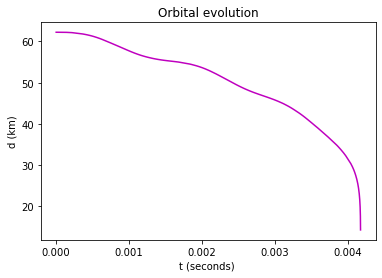

In [54]:
plt.plot(timeTPNsec, dTPN, '-m')
plt.ylabel('d (km)')
plt.xlabel('t (seconds) ')
#plt.savefig('orbital-evolution', format = 'png', dpi =200)
plt.title('Orbital evolution')
plt.show()

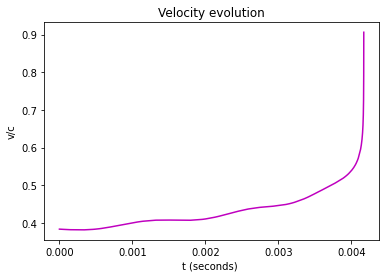

In [55]:
plt.plot(timeTPNsec, vnTPNkm, '-m')
plt.ylabel('v/c')
plt.xlabel('t (seconds) ')
#plt.savefig('velocity-evolution', format = 'png', dpi =200)
plt.title('Velocity evolution')
plt.show()

# GW extraction

In [56]:
wsTPN = np.zeros([len(dTPN)])

for i in range(len(dTPN)):
    wsTPN[i] = ((ns.mass+bh3.mass)/dTPN[i]**3)**(1./2) 
    

In [57]:
hplusTPN = np.zeros([len(dTPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(ns.mass+bh3.mass)

for i in range(len(dTPN)):
    hplusTPN[i] = (1./ro)*(4*mu*(wsTPN[i]**2)*(dTPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsTPN[i]*timeTPN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

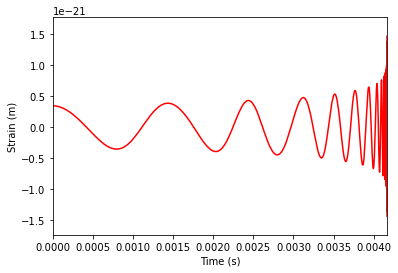

In [58]:
plt.plot(timeTPNsec, hplusTPN, 'r-')
plt.axis([min(timeTPN), max(timeTPNsec), 1.2*min(hplusTPN), 1.2*max(hplusTPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

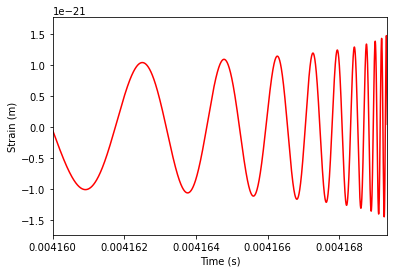

In [59]:
plt.plot(timeTPNsec, hplusTPN, 'r-')
plt.axis([0.00416, max(timeTPNsec), 1.2*min(hplusTPN), 1.2*max(hplusTPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

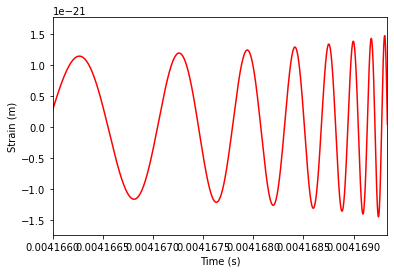

In [85]:
plt.plot(timeTPNsec, hplusTPN, 'r-')
plt.axis([0.004166, max(timeTPNsec), 1.2*min(hplusTPN), 1.2*max(hplusTPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Only PN

In [64]:
def HermiteUpdatePNtdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aTdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aPNp #+ aTp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aTdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    a2c = a2 + dt*a3    
    acn = ((ac**2).sum())**(1./2) #dot product
    a2cn = ((a2c**2).sum())**(1./2)
    adotpn = ((aTdotp**2).sum())**(1./2)
    a3n = ((a3**2).sum())**(1./2)
    dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    #dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, dtp, time #, aN_res, adotN_res, a_res, adot_res, 


In [65]:
accu = 0.0000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 9*bh3nscol.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [66]:
rPN,vPN, dtpPN, timePN, = Hermite4thPNtdt(bh3,ns, bh3nscol, Nsteps, dt)


In [67]:
print(min(dtpPN))
print(max(dtpPN))

5.506294853496029e-05
0.0029527847720116074


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


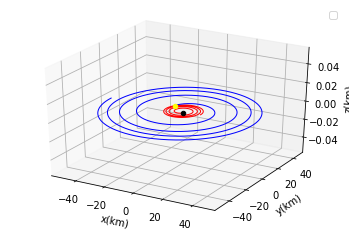

In [127]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPN[0][0], rPN[0][1], rPN[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rPN[1][0], rPN[1][1], rPN[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rPN[0][0][-1], rPN[0][1][-1], rPN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPN[1][0][-1], rPN[1][1][-1], rPN[1][2][-1], '0', c='yellow') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')

#plt.savefig('PNcolns.eps', bbox_inches='tight')#, dpi=200
#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', bbox_inches='tight', format='eps')#,

plt.show()

In [69]:
vPN[0]

array([[ 0.00000000e+00, -3.09871503e-07, -6.19742998e-07, ...,
         4.18655280e-02,  4.18600940e-02,  4.18546597e-02],
       [ 6.10921629e-02,  6.10921613e-02,  6.10921598e-02, ...,
         1.14261178e-01,  1.14264138e-01,  1.14267098e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [95]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])

In [71]:
print(dPN[-1])

14.305425963306298


In [72]:
bh3nscol.tidalrsec

14.305334381906748

In [96]:
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

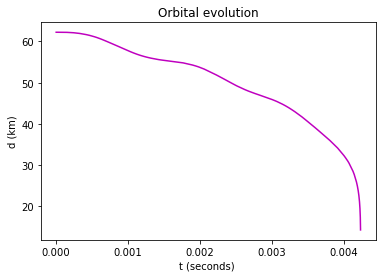

In [97]:
plt.plot(timePNsec, dPN, '-m')
plt.ylabel('d (km)')
plt.xlabel('t (seconds) ')
#plt.savefig('orbital-evolution', format = 'png', dpi =200)
plt.title('Orbital evolution')
plt.show()

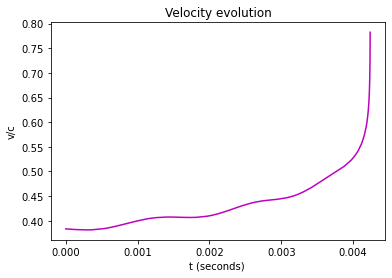

In [99]:
plt.plot(timePNsec, vnrelPNkm, '-m')
plt.ylabel('v/c')
plt.xlabel('t (seconds) ')
#plt.savefig('velocity-evolution', format = 'png', dpi =200)
plt.title('Velocity evolution')
plt.show()

# GW extraction

In [76]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((ns.mass+bh3.mass)/dPN[i]**3)**(1./2) 
    

In [77]:
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(ns.mass+bh3.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

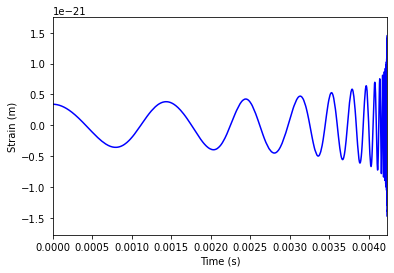

In [78]:
plt.plot(timePNsec, hplusPN, 'b-')
plt.axis([min(timePN), max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

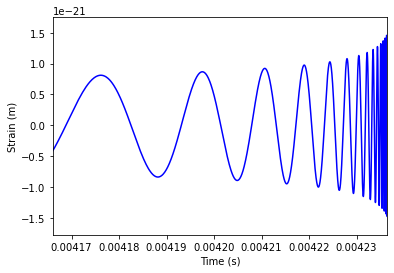

In [79]:
plt.plot(timePNsec, hplusPN, 'b-')
plt.axis([0.004166, max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

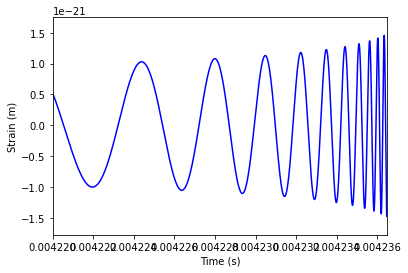

In [80]:
plt.plot(timePNsec, hplusPN, 'b-')
plt.axis([0.00422, max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of Waveforms 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


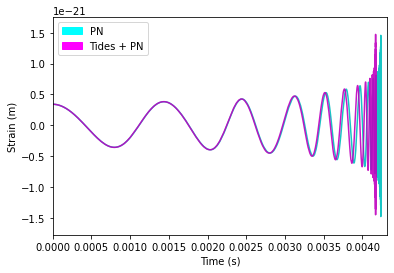

In [160]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'Tides + PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timeTPNsec, hplusTPN, 'm-', alpha = 0.9)
plt.axis([min(timePN), 1.02*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TPNvsPN.eps', bbox_inches='tight') #, dpi=300
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


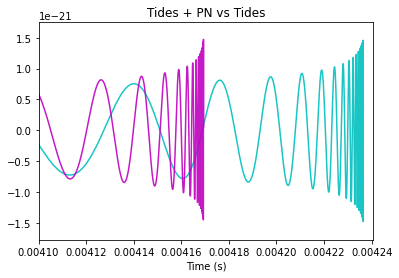

In [119]:
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timeTPNsec, hplusTPN, 'm-', alpha = 0.9)
plt.axis([0.00410, 1.001*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
#plt.ylabel('Strain (m)')
#plt.savefig('gw-TPNvsPN2.eps', bbox_inches='tight')# dpi=300
plt.title('Tides + PN vs Tides')
plt.show()

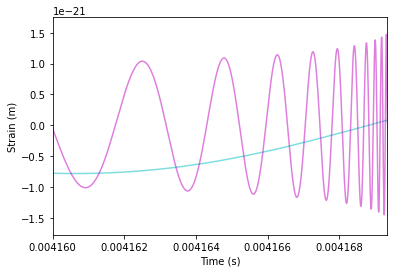

In [83]:
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.5)
plt.plot(timeTPNsec, hplusTPN, 'm-', alpha = 0.5)
plt.axis([0.00416, max(timeTPNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

In [131]:
def HermiteUpdatePNtidedtall(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN + aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aTdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aPNp + aTp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp +  aTdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    a2c = a2 + dt*a3    
    acn = ((ac**2).sum())**(1./2) #dot product
    a2cn = ((a2c**2).sum())**(1./2)
    adotpn = ((aTdotp**2).sum())**(1./2)
    a3n = ((a3**2).sum())**(1./2)
    dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    #dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,ap,adotp,aNp,aNdotp, aPNp, aPNdotp,dtp

def Hermite4thPNtidedtall(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))
    
    aPN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotPN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
    #    #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
    #    elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
    #        break
    
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i],aPN_res[:,:,i],adotPN_res[:,:,i], dtp[i]) = HermiteUpdatePNtidedtall(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    aPN_res = aPN_res[:,:,:i]
    adotPN_res = adotPN_res[:,:,:i]    
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, adot_res, aN_res, adotN_res, aPN_res, adotPN_res, dtp, time 


In [132]:
accu = 0.0000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 9*bh3nscol.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [133]:
rPNT2,vPNT2, aPNT2, adotPNT2, aPNT2_N, adotPNT2_N, aPNT2_PN, adotPNT2_PN,  dtpTPN2, timeTPN2 = Hermite4thPNtidedtall(bh3,ns, bh3nscol, Nsteps, dt)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.29185327e-03,  1.17206840e-05,  0.00000000e+00],
       [ 1.29185321e-03,  1.17272359e-05,  0.00000000e+00],
       ...,
       [ 2.09205680e-02, -4.89609521e-02,  0.00000000e+00],
       [ 2.09253984e-02, -4.89662790e-02,  0.00000000e+00],
       [ 2.09302301e-02, -4.89716072e-02,  0.00000000e+00]])

In [140]:
ac = aPNT2 + adotPNT2*dtpTPN2#Acceleration corrected
aNc = aPNT2_N + adotPNT2_N*dtpTPN2
aPNc = aPNT2_PN + adotPNT2_PN*dtpTPN2

aTPNratio = np.zeros_like(aPNT2[1].T)
aPNratio = np.zeros_like(aPNT2[1].T)
for i in range(len(aPNT2[1].T)-1):
    aTPNratio[i+1][0] = (ac[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aTPNratio[i+1][1] = (ac[1].T[i+1][1])/(aNc[1].T[i+1][1])
    aPNratio[i+1][0] = (aPNc[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aPNratio[i+1][1] = (aPNc[1].T[i+1][1])/(aNc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposT = rPNT2[1].T - rPNT2[0].T 
#define relative velocity
relvelT = vPNT2[1].T - vPNT2[0].T

normrelposT = np.zeros([len(relposT), 1]) 
normrelvelT = np.zeros([len(relvelT), 1]) 

for i in range(len(normrelposT)):
    normrelposT[i] = np.sqrt(relposT[i][0]**2 + relposT[i][1]**2 + relposT[i][2]**2)
    normrelvelT[i] = np.sqrt(relvelT[i][0]**2 + relvelT[i][1]**2 + relvelT[i][2]**2)
    
print(len(normrelposT.T[0]))
print(min(normrelposT))
print(max(normrelposT))

3000766
[14.30545624]
[62.23]


In [141]:
n_ex = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aTPNratio.T[0] - aPNratio.T[0] - 1) 
n_ey = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aTPNratio.T[1] - aPNratio.T[1] -1)

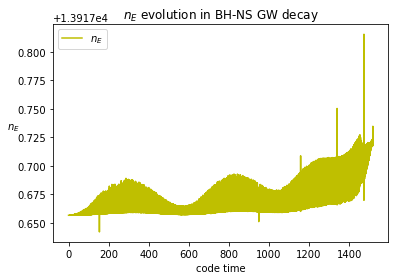

In [154]:
plt.plot(timeTPN2[1:], n_ex[1:], 'y-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ evolution in BH-NS GW decay')
plt.legend()
#plt.savefig('Ne-GWdecay-BHNS.png', bbox_inches='tight', dpi =300)#, dpi=300

plt.show()

In [146]:
print(min(n_ex[1:]))
print(max(n_ex[1:]))
print(ns.ntide)

13917.642043486374
13917.815446191215
13917.65663191198


In [147]:
print(min(n_ey[1:]))
print(max(n_ey[1:]))
print(ns.ntide)

13917.649984134607
13917.757164006294
13917.65663191198
